In [2]:
# data from: https://www.kaggle.com/datasets/bahadoreizadkhah/face-mask-types-dataset/code
# reference: https://towardsdatascience.com/from-alexnet-to-nasnet-a-brief-history-and-introduction-of-convolutional-neural-networks-cf63bf3320e1 
# reference: https://github.com/Alexiush/weak-causality-and-causal-disposition-in-images/blob/main/ca_cnn_sample_resnet.ipynb

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pathlib

In [3]:
data_train = pathlib.Path('./Dataset/train')
data_test = pathlib.Path('./Dataset/test')

INPUT_SIZE = [300, 300]
BATCH = 6

In [4]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.0,
    rescale=1./255
)

training_data = training_datagen.flow_from_directory('./Dataset/train',
                                                     subset="training",
                                                     shuffle=True,
                                                     target_size=INPUT_SIZE,
                                                     batch_size=BATCH,
                                                     color_mode="rgb",
                                                     # interpolation="bilinear", 
                                                     class_mode='categorical')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory('./Dataset/test',
                                             target_size=INPUT_SIZE,
                                             color_mode="rgb",
                                             batch_size=BATCH,
                                             class_mode='categorical',
                                             shuffle=False)

x_test, y_test = next(test_data)
x_train, y_train = next(training_data)

Found 1956 images belonging to 5 classes.
Found 330 images belonging to 5 classes.


In [5]:
# vgg model
inceptionv3_model = tf.keras.applications.InceptionV3(input_shape=(300, 300, 3), include_top=False, weights='imagenet')

inceptionv3_model.trainable = True

fine_tune_at = 100
for layer in inceptionv3_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
flatten = Flatten()(inceptionv3_model.output)
dense_1 = Dense(units=500, activation='relu')(flatten)
dense_2 = Dense(units=500, activation='relu')(dense_1)
dense_3 = Dense(units=100, activation='relu')(dense_2)
dense_4 = Dense(units=100, activation='relu')(dense_3)
dense_output = Dense(units=5, activation='softmax')(dense_4)

model = models.Model(inputs=inceptionv3_model.input, outputs=dense_output)
model.summary()

# [[ 2 69  0  7  0]
#  [ 6 43  0  1  0]
#  [ 3 45  0  1  0]
#  [ 8 14  0 56  0]
#  [ 5 70  0  0  0]]
# 1.4607737064361572 0.3060606122016907

NameError: name 'dense_3' is not defined

In [7]:
# res net model, input/inception/pooling2d/flatten/dense, 0.30895692110061646 0.9242424368858337
inceptionv3_model = tf.keras.applications.InceptionV3(input_shape=(300, 300,3), include_top=False, weights='imagenet')
inceptionv3_model.trainable = True

fine_tune_at = 100
for layer in inceptionv3_model.layers[:fine_tune_at]:
    layer.trainable =  False

model = models.Sequential([# Lambda(lambda x: x, input_shape=(300, 300, 3)), 
    tf.keras.layers.InputLayer((300, 300, 3)),
    inceptionv3_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(5, activation='softmax')])

# [[74  2  2  0  0]
#  [43  4  3  0  0]
#  [22  7 17  0  3]
#  [72  5  1  0  0]
#  [63  5  2  0  5]]

In [ ]:
# inceptionv3 https://www.kaggle.com/code/sasakitetsuya/mask-age-classification-by-inceptionv3
model = tf.keras.models.Sequential()
model.add(inceptionv3_model)
# model.add(tf.keras.layers.Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.summary()

In [15]:
# inceptionv3 https://www.kaggle.com/code/umarmasud/facemask-detection-inceptionv3 
model_pretrained = tf.keras.applications.InceptionV3(weights='imagenet',
                               include_top=False,
                               input_shape=(300, 300, 3))

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer((300, 300, 3)),)
model.add(model_pretrained)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(300, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(100,activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(5, activation="softmax")) 

model.summary()

# epoch 5
# [[ 0  0  0 78  0]
#  [ 0  0  0 50  0]
#  [ 0  0  0 49  0]
#  [ 0  0  0 78  0]
#  [ 0  0  0 75  0]]
#  [ 0. 0. 0. 1. 0.]
# 1.6072306632995605 0.23636363446712494

# [[ 0  0  0 78  0]
#  [ 0  0  0 50  0]
#  [ 0  0  0 49  0]
#  [ 0  0  0 78  0]
#  [ 0  0  0 75  0]]
#  [0. 0. 0. 1. 0.]

# [[74  3  1  0  0]
#  [35 10  5  0  0]
#  [11 25 11  2  0]
#  [61  8  2  7  0]
#  [43 15 16  1  0]]
# 1.617121696472168 0.30909091234207153 

# [[49  0 13 10  6]
#  [23  1 14  3  9]
#  [10  0 29  5  5]
#  [ 4  0  3 71  0]
#  [48  2 15  2  8]]
# 1.1996866464614868 0.4787878692150116

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │       204,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,008,189 (83.95 MB)

 Trainable params: 21,973,757 (83.82 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [8]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)

history = model.fit(
    training_data,
    validation_data=test_data,
    epochs=5,
    # batch_size=BATCH,
    # steps_per_epoch=len(training_data),
    # validation_steps=len(test_data)
)

Epoch 1/5


/Users/ashleycui/miniconda3/envs/tf2/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


326/326 ━━━━━━━━━━━━━━━━━━━━ 215s 629ms/step - accuracy: 0.5533 - loss: 1.1503 - val_accuracy: 0.2727 - val_loss: 7.4781
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 169s 518ms/step - accuracy: 0.7800 - loss: 0.6418 - val_accuracy: 0.6515 - val_loss: 1.5917
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 202s 618ms/step - accuracy: 0.8159 - loss: 0.5389 - val_accuracy: 0.9091 - val_loss: 0.2872
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 164s 501ms/step - accuracy: 0.8789 - loss: 0.3982 - val_accuracy: 0.6788 - val_loss: 1.1202
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 164s 503ms/step - accuracy: 0.8897 - loss: 0.3880 - val_accuracy: 0.9242 - val_loss: 0.3090


In [9]:
#Creacion de la matriz de confusion
y_pred=model.predict(test_data, batch_size=BATCH)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

cm=confusion_matrix(test_data.classes, y_pred)
print(cm)

#Impresion de la exactitud
accu = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accu =accu.diagonal()
print(accu)

#Reporte de metricas
target_names = ['cloth', 'n95', 'n95v', 'nfm', 'srg']
print(classification_report(test_data.classes, y_pred, target_names=target_names, digits=4))

# loss, accuracy, specificity, precision, recall = model.evaluate(test_data, verbose=0)
loss, accuracy = model.evaluate(test_data, verbose=0)

print(loss, accuracy)

55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step
(330, 5)
[0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 4 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 0 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4
 4 4 4 0 4 4 4 0 4 0 4 4 4 4 0 0 4 4 4 0 4 4 0 4 0 4 0 4 4 4 4 4 4 2 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 0 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[[73  2  1  1  1]
 [ 3 47  0  0  0]
 [ 0  0 48  1  0]
 [ 3  0  1 74  0]
 [11  0  1  0 63]]
[0.93589744 0.94       0.97959184 0.94871795 0.84      ]
              precision    recall  f1-score   support

       cloth     0.8111    0.9359    0.8690        78
         n95     0.959

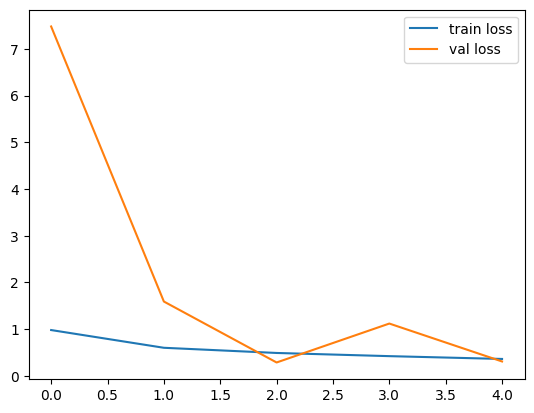

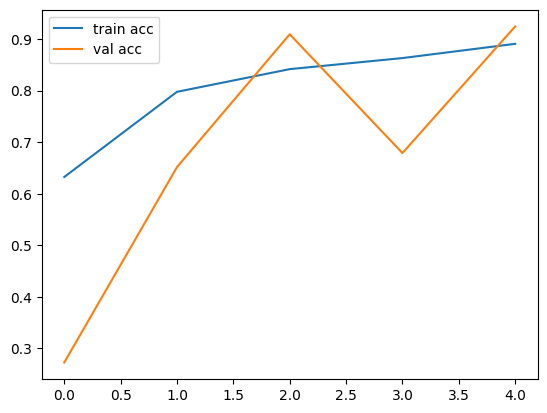

In [12]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')
import numpy as np

In [11]:
test_image = tf.keras.preprocessing.image.load_img(
    './Dataset/test/n95v/1.jpg',
    target_size=INPUT_SIZE)
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = test_image / 255
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
i = np.argmax(result[0])
classes = training_data.class_indices.keys()
print(classes)
list(classes)[i]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
dict_keys(['cloth', 'n95', 'n95v', 'nfm', 'srg'])


'n95v'